In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize

import os

from keras.datasets import mnist

from IPython.display import display

import pickle

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
# I remember that halving is integrated in gridsearch already?
# No, it is stratify, not halving

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_predict

import cv2

#from numba import vectorize, jit, njit
# numba is uninstalled, useless shit

---
### Dataset
---

In [2]:
display(pd.DataFrame(mnist.load_data()).shape)

(X_train, y_train), (X_test, y_test) = mnist.load_data()
display(X_train.shape)
display(X_test.shape)

display(y_train.shape)
display(y_test.shape)

# The images are grey-scaled (might cause some incompetibility with OpenCV)

(2, 2)

(60000, 28, 28)

(10000, 28, 28)

(60000,)

(10000,)

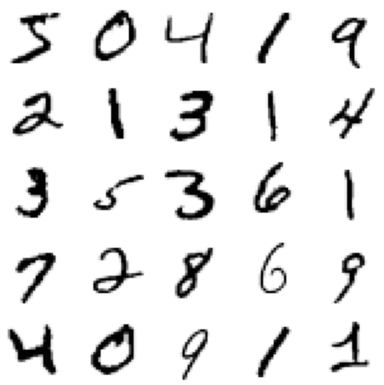

In [3]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8), dpi=50)
plt.rcParams["savefig.pad_inches"] = 0

i = 0
for ax in axes.reshape(25):
    #ax.set_axis_off()
    ax.axis('off')
    ax.imshow(X_train[i], cmap=plt.get_cmap("Greys"))
    i += 1
    
plt.tight_layout()
#plt.savefig('./img_resize_test/shrinking_test_OG.jpg', bbox_inches='tight')

28*28 resolution might be an overkill for digit recognition, let's try to downgrade it to smaller images to save cumputing power

---
### Bluring images
---

Exploring interpolation algorithm for shrinking (OpenCV)

In [4]:

'''
fig = plt.figure()
plt.axis('off')
img = plt.imshow(X_train[0], cmap='Greys')
plt.tight_layout()
plt.savefig('your_image.jpg')
'''
new_res = 12
# imread(..., 0) . read image files as greyscale images, else it will be in rgb
img = cv2.imread('./img_resize_test/shrinking_test_OG.jpg', 0)
res_AREA = cv2.resize(img, dsize=(new_res*5, new_res*5), interpolation=cv2.INTER_AREA)
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_AREA.jpg', res_AREA)

res_BITS = cv2.resize(img, dsize=(new_res*5, new_res*5), interpolation=cv2.INTER_BITS)
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_BITS.jpg', res_BITS)

res_LINEAR = cv2.resize(img, dsize=(new_res*5, new_res*5), interpolation=cv2.INTER_LINEAR)
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_LINEAR.jpg', res_LINEAR)

res_CUBIC = cv2.resize(img, dsize=(new_res*5, new_res*5), interpolation=cv2.INTER_CUBIC)
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_CUBIC.jpg', res_CUBIC)

# Go to ./img_resize_test to see all the results


In [5]:
# There are some noise pixels after shrinking, we will deal with it through cv2.threshold 
# the gray noises after this section are just display problem, not about raw data (all 0 | 255)

res_AREA_thresh = cv2.threshold(res_AREA, 0, 255, cv2.THRESH_OTSU)[1]
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_AREA_thresh.jpg', res_AREA_thresh)

res_BITS_thresh = cv2.threshold(res_BITS, 0, 255, cv2.THRESH_OTSU)[1]
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_BITS_thresh.jpg', res_BITS_thresh)

res_LINEAR_thresh = cv2.threshold(res_LINEAR, 0, 255, cv2.THRESH_OTSU)[1]
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_LINEAR_thresh.jpg', res_LINEAR_thresh)

res_CUBIC_thresh = cv2.threshold(res_CUBIC, 0, 255, cv2.THRESH_OTSU)[1]
#cv2.imwrite('./img_resize_test/shrinking_test_resized_INTER_CUBIC_thresh.jpg', res_CUBIC_thresh)


 
Seems like INTER_LINEAR preserves the most usable info after thresholding

---
### Preprocessing Algorithm Selection 
--- 

We intend to optimize the preprocessed data for two adverse goals: 1) Space complexity; 2) Preserving principal information (like the outline, little curves of the digits)

(2, 0); (0, 4); (1, 4); (3, 4) are important for choosing the smallest possible resolution  
(3, 3); (2, 0); are important for choosing between interpolation method under appropriate resolution
* (a, b) meaning the digit on a+1 row, b+1 column  

We landed on **INTER_LINEAR without thresholding** as the go to preprocessing method

In [6]:
def preprocess(imgs):
    new_res = 12
    length = imgs.shape[0]
    imgs_degrade = np.zeros((length, new_res, new_res))
    for img_i in range(length):
        # converge to 8-bit greyscale (0-255, back-white) (seems like not needed)
        #mask_gray = cv2.normalize(src=imgs[img_i], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        imgs_degrade[img_i] = cv2.resize(imgs[img_i], dsize=(new_res, new_res), interpolation=cv2.INTER_AREA)
        #plt.imshow(imgs_degrade[img_i])
        
        
    return imgs_degrade
    

Preprocess X_train and X_test

In [7]:
X_train_degraded = preprocess(X_train)
X_test_degraded = preprocess(X_test)

Random sample for validation

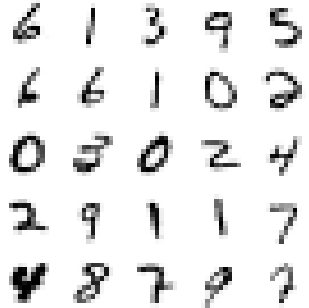

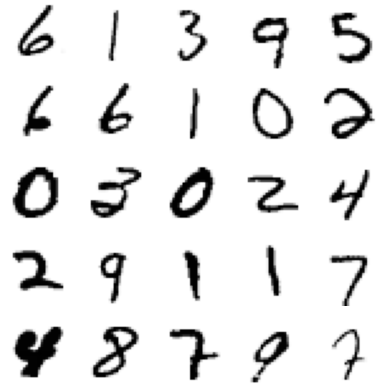

In [8]:
fig1, axes1 = plt.subplots(5, 5, figsize=(8, 8), dpi=50)
fig2, axes2 = plt.subplots(5, 5, figsize=(8, 8), dpi=50)
plt.rcParams["savefig.pad_inches"] = 0

i = 0
for ax1, ax2 in list(zip(axes1.reshape(25), axes2.reshape(25))):
    j = np.random.randint(60000)
    #ax.set_axis_off()
    ax1.axis('off')
    ax1.imshow(X_train_degraded[j], cmap=plt.get_cmap("Greys"))
    ax2.axis('off')
    ax2.imshow(X_train[j], cmap=plt.get_cmap("Greys"))
    i += 1
    
plt.tight_layout()

---
### Baseline Model (Logistic)
---

In [9]:
# All params set to common default vlaues
'''
clf_base = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #L2 regularization
                        solver='saga',
                        max_iter=10000,
                        C=200)
                        '''

"\nclf_base = LogisticRegression(fit_intercept=True,\n                        multi_class='auto',\n                        penalty='l2', #L2 regularization\n                        solver='saga',\n                        max_iter=10000,\n                        C=200)\n                        "

In [10]:
# reshape to fit models (flatten)
X_train_degraded_flatten = X_train_degraded.reshape(len(X_train), new_res**2)
X_test_degraded_flatted = X_test_degraded.reshape(len(X_test), new_res**2)

In [11]:
#clf_base.fit(X_train_degraded_flatten, y_train)

In [12]:
# Time cost: 16min
#pickle.dump(clf_base, open('./models/clf_base.sav', 'wb'))

---
#### Evaluation
---

In [13]:
clf_base = pickle.load(open('./models/clf_base.sav', 'rb'))

/Users/ilpreterosso/miniconda/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
print(clf_base.score(X_train_degraded_flatten, y_train))

y_pred = clf_base.predict(X_test_degraded_flatted)
print(classification_report(y_test, y_pred))

0.927
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.86      0.88       892
           6       0.95      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.90      0.89       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Understand what's going on

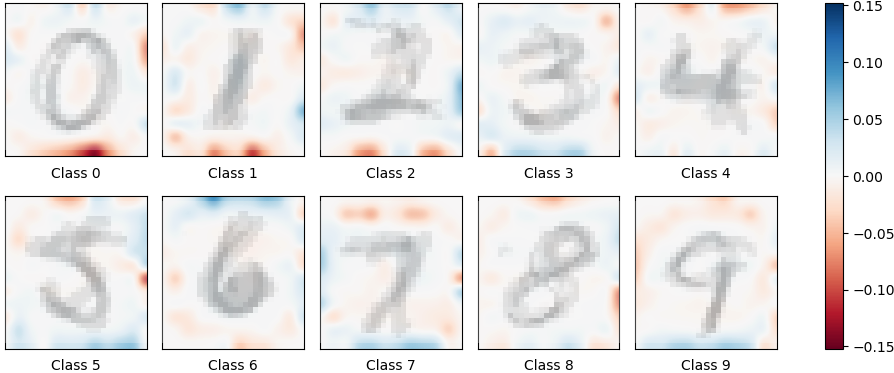

In [15]:
#plt.style.use('seaborn')
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#MMS = MinMaxScaler()

coef = clf_base.coef_.copy()
scale = np.max(np.abs(coef))*.9
fig, axes = plt.subplots(2, 5, figsize=(10, 4))


axes = axes.flatten()
for i in clf_base.classes_:
    ax = axes[i]
    temp = coef[i]
    temp = temp.reshape(new_res, new_res)
    img = ax.imshow(temp , cmap=plt.get_cmap("RdBu"), vmin=-scale, vmax=scale, interpolation='gaussian')
    #sns.heatmap(coef[i].reshape(new_res, new_res), ax=ax, cmap=plt.get_cmap("RdBu_r"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Class {}".format(i))
    
    
    ########### Fancy moves
    ax_ = ax.twiny()
    ax_.get_shared_y_axes().remove(ax_)
    # add new yaxis
    # remark: axis doesn't include labels
    
    yticker = matplotlib.axis.Ticker()
    ax_.yaxis.major = yticker

    # The new ticker needs new locator and formatters
    yloc = matplotlib.ticker.AutoLocator()
    yfmt = matplotlib.ticker.ScalarFormatter()

    ax_.yaxis.set_major_locator(yloc)
    ax_.yaxis.set_major_formatter(yfmt)
    ax_.axis('off')
    
    find = np.where(y_test == i)[0]
    for k in range(3):
        j = np.random.randint(len(find))
        ax_.imshow(X_test[find[j]], cmap='Greys', alpha=.1)
        

plt.tight_layout()
_ = fig.colorbar(img, ax = axes)
#plt.savefig('coef_heatmap.jpg', transparent=True, dpi=200)

---
### Adverserial Attack
---

GPU calculation just for fun! Well too slow so I removed them 
Imagine the photos are taken under limited lighting condition, where noises appears in the photos taken

import torch

device = torch.device('mps' if torch.has_mps else 'cpu')
device

X_train_degraded_tor = torch.from_numpy(X_train_degraded).float().to(device)
X_test_degraded_tor = torch.from_numpy(X_test_degraded).float().to(device)
y_train_tor = torch.from_numpy(y_train).float().to(device)
y_test_tor = torch.from_numpy(y_test).float().to(device)

def gauss_noise(imgs):
    var = torch.tensor(10, dtype=torch.int8, device=device)
    mean = torch.tensor(255//2, dtype=torch.int8, device=device)
    shape = imgs[0].shape
    
    for img_i in range(len(imgs)):
        img = imgs[img_i]
        noise = torch.sqrt(var) * torch.randn(shape, device=device) + mean
        imgs[img_i] = img + noise

    return imgs

In [16]:
def gauss_noise(imgs, var=25):
    shape = imgs[0].shape
    
    imgs_noise = np.zeros((len(imgs), shape[0], shape[1]))
    
    for img_i in range(len(imgs)):
        img = imgs[img_i]
        noise = np.sqrt(var) * np.random.randn(shape[0], shape[1])
        img_noise = img + noise
        # Make sure noised images still in 0 - 255
        img_noise = ((img_noise - img_noise.min()) / img_noise.max()) * 255
        imgs_noise[img_i] = img_noise
        

    return imgs_noise

In [21]:
X_train_degraded_noise = gauss_noise(X_train_degraded)
X_test_degraded_noise = gauss_noise(X_test_degraded)

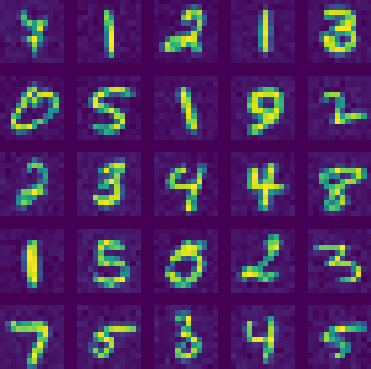

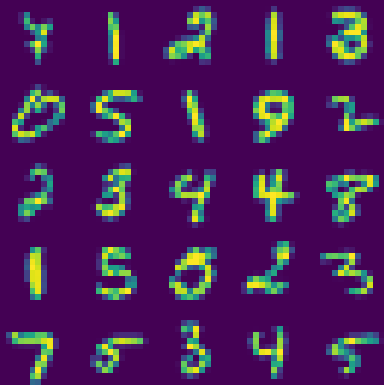

In [18]:
fig1, axes1 = plt.subplots(5, 5, figsize=(8, 8), dpi=60)
fig2, axes2 = plt.subplots(5, 5, figsize=(8, 8), dpi=50)
plt.rcParams["savefig.pad_inches"] = 0


i = 0
for ax1, ax2 in list(zip(axes1.reshape(25), axes2.reshape(25))):
    j = np.random.randint(10000)
    #ax.set_axis_off()
    ax1.axis('off')
    ax1.imshow(X_test_degraded_noise[j])
    ax2.axis('off')
    ax2.imshow(X_test_degraded[j])
    i += 1
    
# make figure color coheres
cmap= plt.get_cmap('viridis')
fig1.set_facecolor(cmap(0))
fig2.set_facecolor(cmap(0))
    
plt.tight_layout()

---
#### Evaluation
---

In [181]:
y_pred_noise = clf_base.predict(X_test_degraded_noise.reshape(len(X_test), new_res**2))
print(classification_report(y_test, y_pred_noise))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       980
           1       0.00      0.00      0.00      1135
           2       0.27      0.95      0.42      1032
           3       0.68      0.36      0.47      1010
           4       1.00      0.04      0.07       982
           5       0.20      0.93      0.34       892
           6       0.75      0.69      0.72       958
           7       0.78      0.61      0.69      1028
           8       0.67      0.00      0.00       974
           9       1.00      0.00      0.01      1009

    accuracy                           0.35     10000
   macro avg       0.64      0.36      0.27     10000
weighted avg       0.63      0.35      0.27     10000



In [200]:
vars = np.linspace(0, 50, 10).tolist() + np.linspace(100, 200, 4).tolist()
f1s = []
for var in vars:
    X_test_degraded_noise = gauss_noise(X_test_degraded, var=var)
    y_pred_noise = clf_base.predict(X_test_degraded_noise.reshape(len(X_test), new_res**2))
    f1s.append(f1_score(y_test, y_pred_noise, average='weighted'))

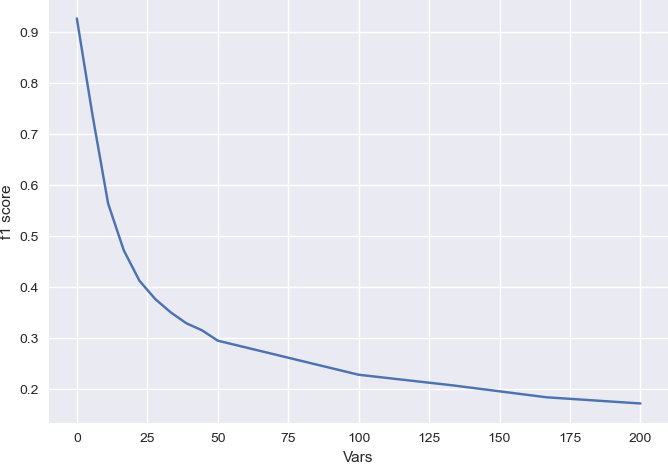

In [201]:
plt.style.use('seaborn')
plt.plot(vars, f1s)
plt.xlabel('Vars')
plt.ylabel('f1 score')
plt.savefig('var_f1.jpg')

---
### Robust Training
---

In [19]:
# The same model
'''
clf_base_robust = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #L2 regularization
                        solver='saga',
                        max_iter=10000,
                        C=200)
                        '''

In [23]:
X_train_degraded_noise_flatten = X_train_degraded_noise.reshape(len(X_train), new_res**2)
X_test_degraded_noise_flatten = X_test_degraded_noise.reshape(len(X_test), new_res**2)

In [24]:
#clf_base_robust.fit(X_train_degraded_noise_flatten, y_train)
# Time cost only 2min27s???

LogisticRegression(C=200, max_iter=10000, solver='saga')

In [25]:
#pickle.dump(clf_base_robust, open('./models/clf_base_robust.sav', 'wb'))

In [28]:
clf_base_robust = pickle.load(open('./models/clf_base_robust.sav', 'rb'))

In [29]:
y_pred_robust = clf_base_robust.predict(X_test_degraded_noise_flatten)

In [31]:
print(clf_base.score(X_train_degraded_noise_flatten, y_train))
print(clf_base_robust.score(X_train_degraded_noise_flatten, y_train))
print(classification_report(y_test, y_pred_robust))

0.4588833333333333
0.9225833333333333
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.94      0.93      0.93      1028
           8       0.87      0.88      0.88       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [32]:
y_pred_OG = clf_base_robust.predict(X_test_degraded_flatted)

In [33]:
print(classification_report(y_test, y_pred_OG))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.98      0.96      0.97      1135
           2       0.94      0.86      0.90      1032
           3       0.89      0.92      0.90      1010
           4       0.93      0.92      0.92       982
           5       0.99      0.63      0.77       892
           6       0.94      0.96      0.95       958
           7       0.97      0.89      0.93      1028
           8       0.69      0.96      0.80       974
           9       0.89      0.92      0.90      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



Which is surprisingly good!

In [35]:
vars = np.linspace(0, 50, 10).tolist() + np.linspace(100, 200, 4).tolist()
f1s = []
for var in vars:
    X_test_degraded_noise = gauss_noise(X_test_degraded, var=var)
    y_pred_noise = clf_base_robust.predict(X_test_degraded_noise.reshape(len(X_test), new_res**2))
    f1s.append(f1_score(y_test, y_pred_noise, average='weighted'))

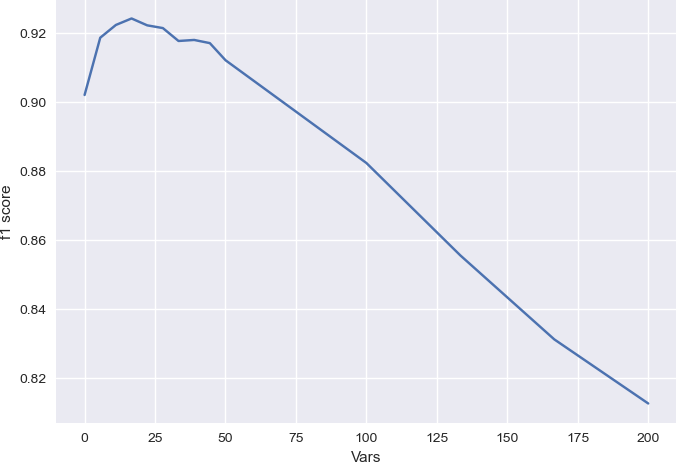

In [36]:
plt.style.use('seaborn')
plt.plot(vars, f1s)
plt.xlabel('Vars')
plt.ylabel('f1 score')
plt.savefig('var_f1.jpg')

---
### Look into the model, again
---

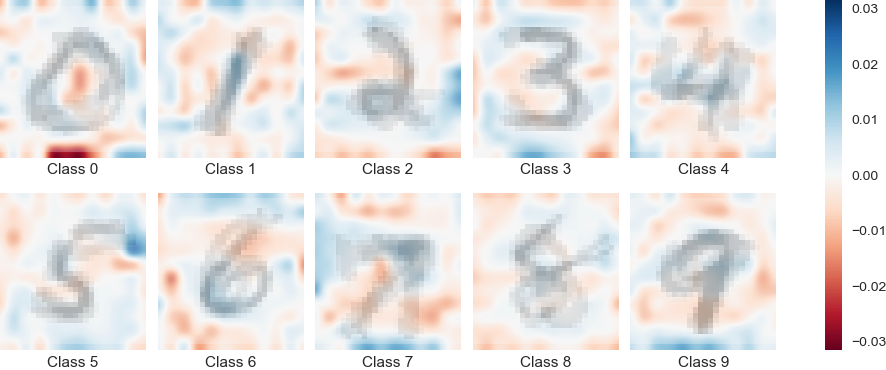

In [39]:
coef = clf_base_robust.coef_.copy()
scale = np.max(np.abs(coef))*.9
fig, axes = plt.subplots(2, 5, figsize=(10, 4))


axes = axes.flatten()
for i in clf_base.classes_:
    ax = axes[i]
    temp = coef[i]
    temp = temp.reshape(new_res, new_res)
    img = ax.imshow(temp , cmap=plt.get_cmap("RdBu"), vmin=-scale, vmax=scale, interpolation='gaussian')
    #sns.heatmap(coef[i].reshape(new_res, new_res), ax=ax, cmap=plt.get_cmap("RdBu_r"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Class {}".format(i))
    
    
    ########### Fancy moves
    ax_ = ax.twiny()
    ax_.get_shared_y_axes().remove(ax_)
    # add new yaxis
    # remark: axis doesn't include labels
    
    yticker = matplotlib.axis.Ticker()
    ax_.yaxis.major = yticker

    # The new ticker needs new locator and formatters
    yloc = matplotlib.ticker.AutoLocator()
    yfmt = matplotlib.ticker.ScalarFormatter()

    ax_.yaxis.set_major_locator(yloc)
    ax_.yaxis.set_major_formatter(yfmt)
    ax_.axis('off')
    
    find = np.where(y_test == i)[0]
    for k in range(3):
        j = np.random.randint(len(find))
        ax_.imshow(X_test[find[j]], cmap='Greys', alpha=.1)
        

plt.tight_layout()
_ = fig.colorbar(img, ax = axes)
#plt.savefig('coef_robust_heatmap.jpg', transparent=True, dpi=200)

Looks much more 'red' than before (a stronger boundary)

More robust! Quatradic deminish in f1 turns into linear deminish  
For real case application, use the augmentated dataset (OG + Noised)  
to train might even get rid of the little 'bump' to the left

(Into Background) We din't chose an advanced topics, because machine learning solutions to real wrold problems will very easily introduce a 'brute force pitfall' of plug in over-sized data and optimize for higher yet clueless scores. We believe that the insight into the distribution, structure of a dataset and the careful data engeneering will manifest their importance as our study and models get more complex and comprehensive. Therefore this report puts more weights on the 'what's' and 'why's' behind the scene than necessity. 